In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import re
from pandas import concat
import tsfresh
from sklearn import preprocessing
from sklearn import utils
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd

In [2]:
# load dataset
dataset = read_csv('NSE-Data-new back upcsv.csv',header=0, index_col=0)

In [3]:
print(dataset.head(2))

            Nifty    Volume      Turnover      EMA-200      EMA-100  \
Date                                                                  
1/3/2005  2115.00  70506865  2.375100e+10  1807.768326  1863.544641   
1/4/2005  2103.75  72718302  2.416130e+10  1810.713417  1868.301183   

               EMA-50     EMA-21        EMA-5       MACD     RSI-14  ...  \
Date                                                                 ...   
1/3/2005  1951.264565  2031.2347  2083.265125  43.080270  78.071485  ...   
1/4/2005  1957.244386  2037.8270  2090.093417  43.440559  73.511082  ...   

          BollingerMiddleBand  BollingerLowerBand  Brent Crude Price  \
Date                                                                   
1/3/2005              2079.25         2041.161051                NaN   
1/4/2005              2085.73         2044.340649              41.04   

            Dow Price    FTSE  Hang Seng Price  USD-INR price  \
Date                                                    

In [4]:
# function to shift left and shift forward the time series dataframe where n_in paramter used to shift left and n_out parameter used to shift right
def series_to_new_supervised(df, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(df) is list else df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    #names = df.columns.values
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(' %s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]

    	# forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(' %s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [(' %s(t+%d)' % (df.columns[j], i))for j in range(n_vars)]
    	# put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    else:
        agg = agg.fillna(0)
    return agg

In [5]:
#Columns to be removed from the transformed series. For example - after time series is shifted to N+1, you may want only-
#columns in shifted time series i.e you may want only Nifty rest other columns can be droped from N+1
def remove_columns_from_transformed_series(df2, main_column, negative, positive):
    columns_to_be_removed=[]
    for i in range(0,df2.shape[1]):
        string1=df2.columns[i]
        if re.search("\(t\-",string1): 
            if not (re.search(main_column,string1)):
                if (negative==1):
                    columns_to_be_removed.append(string1)
        if re.search("\(t\+",string1):
            if not (re.search(main_column,string1)):
                if (positive==1):
                    columns_to_be_removed.append(string1)
    df2.drop(columns_to_be_removed, axis=1, inplace=True)
    return df2
    

In [6]:
#shift series to right to get the Y column that is next day Nifty values and all other technical columns
shiftRightSeries=series_to_new_supervised(dataset,0,2)
print(shiftRightSeries.head(2))

          Nifty(t)  Volume(t)   Turnover(t)   EMA-200(t)   EMA-100(t)  \
Date                                                                    
1/4/2005   2103.75   72718302  2.416130e+10  1810.713417  1868.301183   
1/5/2005   2032.20  109223487  3.622020e+10  1812.917264  1871.546704   

            EMA-50(t)    EMA-21(t)     EMA-5(t)    MACD(t)  RSI-14(t)  ...  \
Date                                                                   ...   
1/4/2005  1957.244386  2037.827000  2090.093417  43.440559  73.511082  ...   
1/5/2005  1960.183822  2037.315454  2070.795611  37.520096  52.504718  ...   

          BollingerMiddleBand(t+1)  BollingerLowerBand(t+1)  \
Date                                                          
1/4/2005                   2078.25              2018.471208   
1/5/2005                   2065.96              1977.618540   

          Brent Crude Price(t+1)  Dow Price(t+1)  FTSE(t+1)  \
Date                                                          
1/4/2005       

In [7]:
#As we are interested to predict only Nifty value, we can drop off all other technical columns from Output and keep only Nifty(t+1)

shiftRightSeries=remove_columns_from_transformed_series(shiftRightSeries,"Nifty",1,1)
print(shiftRightSeries.head(5))

           Nifty(t)  Volume(t)   Turnover(t)   EMA-200(t)   EMA-100(t)  \
Date                                                                     
1/4/2005    2103.75   72718302  2.416130e+10  1810.713417  1868.301183   
1/5/2005    2032.20  109223487  3.622020e+10  1812.917264  1871.546704   
1/6/2005    1998.35   94321939  3.233820e+10  1814.762366  1874.057661   
1/7/2005    2015.50   76285818  2.764030e+10  1816.759755  1876.858499   
1/10/2005   1982.00   75659206  2.349260e+10  1818.403937  1878.940509   

             EMA-50(t)    EMA-21(t)     EMA-5(t)    MACD(t)  RSI-14(t)  ...  \
Date                                                                    ...   
1/4/2005   1957.244386  2037.827000  2090.093417  43.440559  73.511082  ...   
1/5/2005   1960.183822  2037.315454  2070.795611  37.520096  52.504718  ...   
1/6/2005   1961.680535  2033.773140  2046.647074  29.753693  45.832030  ...   
1/7/2005   1963.791102  2032.111946  2036.264716  24.697921  49.344550  ...   
1/10/20

In [8]:
#Seperate Independant and dependant variables in X and Y respectively
X=shiftRightSeries.iloc[:,:-1]
y=shiftRightSeries.iloc[:,-1]
print(X.head(2))
print(y.head(2))

          Nifty(t)  Volume(t)   Turnover(t)   EMA-200(t)   EMA-100(t)  \
Date                                                                    
1/4/2005   2103.75   72718302  2.416130e+10  1810.713417  1868.301183   
1/5/2005   2032.20  109223487  3.622020e+10  1812.917264  1871.546704   

            EMA-50(t)    EMA-21(t)     EMA-5(t)    MACD(t)  RSI-14(t)  ...  \
Date                                                                   ...   
1/4/2005  1957.244386  2037.827000  2090.093417  43.440559  73.511082  ...   
1/5/2005  1960.183822  2037.315454  2070.795611  37.520096  52.504718  ...   

          BollingerMiddleBand(t)  BollingerLowerBand(t)  Brent Crude Price(t)  \
Date                                                                            
1/4/2005                 2085.73            2044.340649                 41.04   
1/5/2005                 2078.25            2018.471208                 40.51   

          Dow Price(t)  FTSE(t)  Hang Seng Price(t)  USD-INR price(t)

In [9]:
#One of the common issue related to machine learning problem- Y variable (if int or float) throws error when you fit the logistic regression model
#In order to solve it, you may need to convert the Y variable to label encoded format

lab_enc = preprocessing.LabelEncoder()
y_scores_encoded = lab_enc.fit_transform(y)
print(utils.multiclass.type_of_target(y_scores_encoded))

multiclass


In [10]:
# model = LogisticRegression()
# rfe = RFE(estimator=model, n_features_to_select=10)
# fit = rfe.fit(X, y_scores_encoded)
# print("Num Features: %d" % (fit.n_features_,))
# print("Selected Features: %s" % (fit.support_,))
# print("Feature Ranking: %s" % (fit.ranking_,))

In [11]:
#Identifying the importance of feature based on ExtraTreeClassifications
model = ExtraTreesClassifier()
model.fit(X,y_scores_encoded)
# display the relative importance of each attribute
print(model.feature_importances_)

[0.04870332 0.04727707 0.04683425 0.04692508 0.0484956  0.04806942
 0.04824501 0.048238   0.04773255 0.04796185 0.04823716 0.04833034
 0.04815745 0.04782161 0.04760805 0.0468486  0.04688843 0.04687314
 0.04747474 0.04665666 0.04662166]


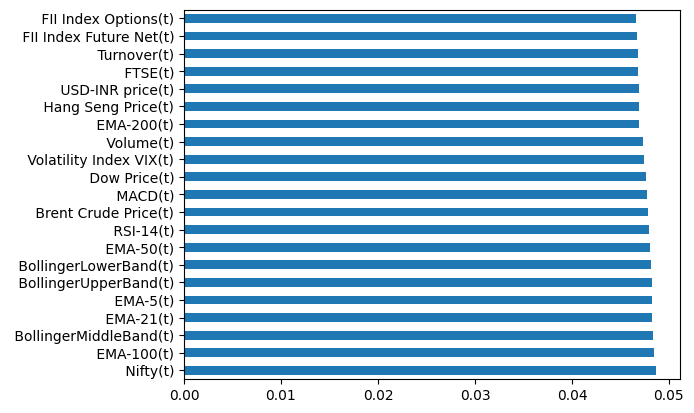

In [12]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(21).plot(kind='barh')
pyplot.show()


In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(shiftRightSeries)

X_new=scaled[:,:-1]
y_new=scaled[:,-1]
lab_enc = preprocessing.LabelEncoder()
y_scores_encoded_new = lab_enc.fit_transform(y_new)
print(y_scores_encoded_new)
print(utils.multiclass.type_of_target(y_new))
print(utils.multiclass.type_of_target(y_scores_encoded))

[  52   38   45 ... 3499 3517 3506]
continuous
multiclass


                       Specs       Score
17          USD-INR price(t)  676.985024
5                  EMA-50(t)  556.558619
6                  EMA-21(t)  552.139495
4                 EMA-100(t)  550.181670
3                 EMA-200(t)  550.082539
12     BollingerLowerBand(t)  542.605087
11    BollingerMiddleBand(t)  538.227012
7                   EMA-5(t)  537.801351
0                   Nifty(t)  528.489901
10     BollingerUpperBand(t)  523.966081
14              Dow Price(t)  496.904937
18   Volatility Index VIX(t)  393.440538
13      Brent Crude Price(t)  376.710317
16        Hang Seng Price(t)  274.480597
15                   FTSE(t)  231.418879
1                  Volume(t)  225.446605
2                Turnover(t)  219.674478
9                  RSI-14(t)  217.358698
8                    MACD(t)   99.041005
19   FII Index Future Net(t)   21.178951
20      FII Index Options(t)   11.677231


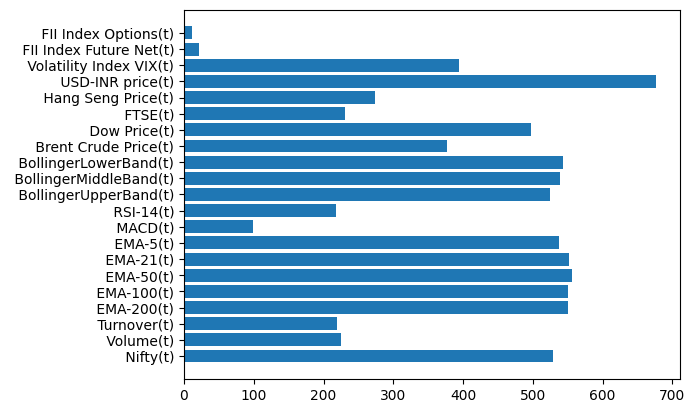

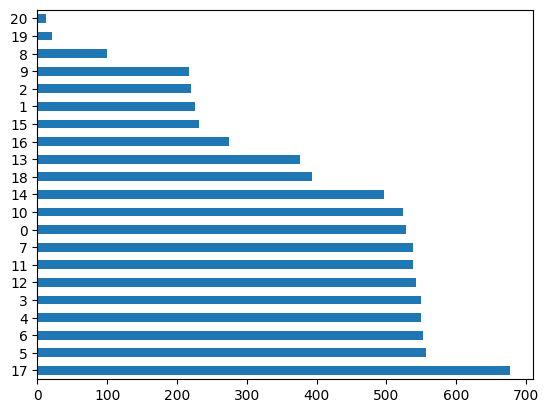

                       Specs       Score
0                   Nifty(t)  528.489901
1                  Volume(t)  225.446605
2                Turnover(t)  219.674478
3                 EMA-200(t)  550.082539
4                 EMA-100(t)  550.181670
5                  EMA-50(t)  556.558619
6                  EMA-21(t)  552.139495
7                   EMA-5(t)  537.801351
8                    MACD(t)   99.041005
9                  RSI-14(t)  217.358698
10     BollingerUpperBand(t)  523.966081
11    BollingerMiddleBand(t)  538.227012
12     BollingerLowerBand(t)  542.605087
13      Brent Crude Price(t)  376.710317
14              Dow Price(t)  496.904937
15                   FTSE(t)  231.418879
16        Hang Seng Price(t)  274.480597
17          USD-INR price(t)  676.985024
18   Volatility Index VIX(t)  393.440538
19   FII Index Future Net(t)   21.178951
20      FII Index Options(t)   11.677231


In [14]:
#plot graph of feature importances for better visualization
#feat_importances = pd.Series(featureScores['Score'],index=featureScores['Specs'])
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=chi2, k=21)
fit = bestfeatures.fit(X_new,y_scores_encoded_new)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(21,'Score'))  #print 10 best features
pyplot.barh(featureScores['Specs'],featureScores['Score'])
pyplot.show()
featureScores['Score'].nlargest(21).plot(kind='barh')
pyplot.show()
print(featureScores)

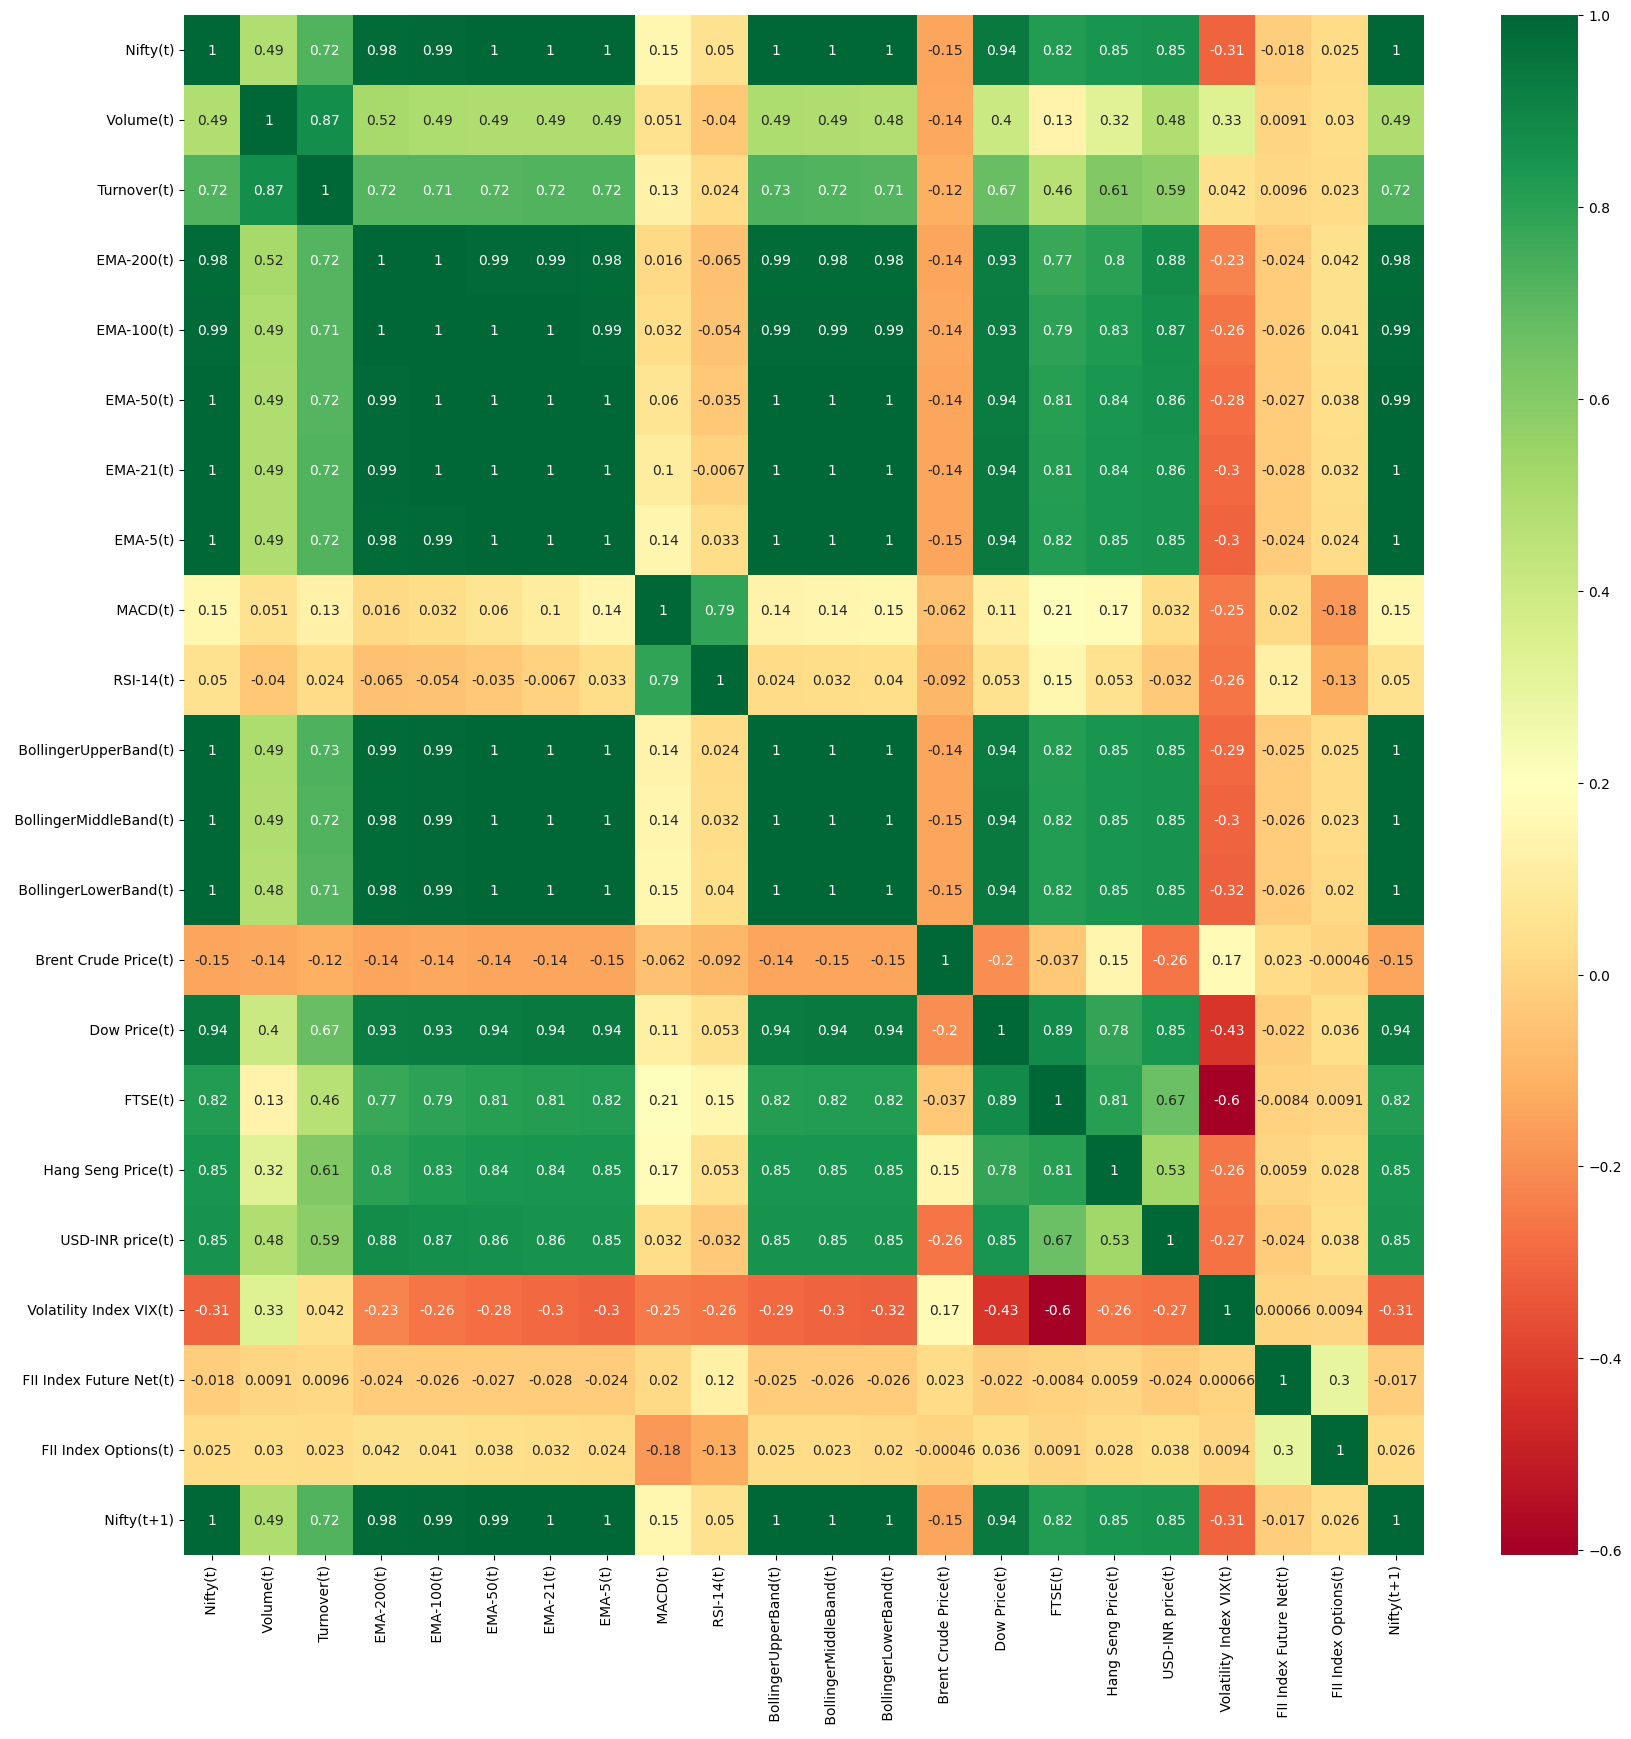

In [15]:
!pip install seaborn
import seaborn as sns
#get correlations of each features in dataset
corrmat = shiftRightSeries.corr()
top_corr_features = corrmat.index
pyplot.figure(figsize=(20,20))#Based on all the above feature seclection menthods- (Top 10 features are selected for which Independant Y is highly dependant on)
#Point to note- Feature selection filtered only leading indicators and removing the lagging indicators such as MACD and RSI
#USD-INR(t)
#EMA-50(t)
#EMA-200(t)
#EMA-100(t)
#EMA-21(t)
#EMA-5(t)
#BollingerLowerBand(t)
#BollingerMiddleBand(t)
#Nifty(t)
#BollingerUpperBand(t)
#Dow Price(t)
#IndiaVIX(t)
#plot heat map
g=sns.heatmap(shiftRightSeries[top_corr_features].corr(),annot=True,cmap="RdYlGn")#Based on all the above feature seclection menthods- (Top 10 features are selected for which Independant Y is highly dependant on)
#Point to note- Feature selection filtered only leading indicators and removing the lagging indicators such as MACD and RSI
#USD-INR(t)
#EMA-50(t)
#EMA-200(t)
#EMA-100(t)
#EMA-21(t)
#EMA-5(t)
#BollingerLowerBand(t)
#BollingerMiddleBand(t)
#Nifty(t)
#BollingerUpperBand(t)
#Dow Price(t)
#IndiaVIX(t)

In [16]:
#=================This completes feature filtering=================================

In [17]:
#Removing the columns which are less significant such as MACD, RSI, FTSE, Hang Seng, Future Index, Bent Crude
removeColumns= ["FII Index Options","Volume","FTSE","Brent Crude Price","RSI-14","MACD","Turnover"]
for removeColumnvalue in removeColumns:
    if removeColumnvalue in dataset.columns:
        dataset.drop(removeColumnvalue, axis=1, inplace=True)
print(dataset.head(2))
print(dataset.columns)
t_features=len(dataset.columns)
print(t_features)
timesteps=5
sequence=t_features*timesteps

            Nifty      EMA-200      EMA-100       EMA-50     EMA-21  \
Date                                                                  
1/3/2005  2115.00  1807.768326  1863.544641  1951.264565  2031.2347   
1/4/2005  2103.75  1810.713417  1868.301183  1957.244386  2037.8270   

                EMA-5  BollingerUpperBand  BollingerMiddleBand  \
Date                                                             
1/3/2005  2083.265125         2117.338949              2079.25   
1/4/2005  2090.093417         2127.119351              2085.73   

          BollingerLowerBand    Dow Price  Hang Seng Price  USD-INR price  \
Date                                                                        
1/3/2005         2041.161051  10729.42969         14237.42         43.400   
1/4/2005         2044.340649  10630.78027         14045.90         43.495   

          Volatility Index VIX  FII Index Future Net  
Date                                                  
1/3/2005                 14.08 

In [18]:
# reframing the time series to have (t-5) data in order to create LSTM time series model
reframe_series_5=series_to_new_supervised(dataset,5,1)
reframe_series_5=remove_columns_from_transformed_series(reframe_series_5,"Nifty",0,1)
print(reframe_series_5.tail(2))

           Nifty(t-5)  EMA-200(t-5)  EMA-100(t-5)  EMA-50(t-5)  EMA-21(t-5)  \
Date                                                                          
6/20/2019    11914.05   11174.31912   11429.88996  11648.95155  11821.18927   
6/21/2019    11823.30   11180.77664   11437.68026  11655.78874  11821.38115   

            EMA-5(t-5)  BollingerUpperBand(t-5)  BollingerMiddleBand(t-5)  \
Date                                                                        
6/20/2019  11920.47869              11976.90644                  11915.84   
6/21/2019  11888.08579              11999.03930                  11906.37   

           BollingerLowerBand(t-5)  Dow Price(t-5)  ...    EMA-21(t)  \
Date                                                ...                
6/20/2019              11854.77356        26106.77  ...  11791.63481   
6/21/2019              11813.70070        26089.61  ...  11785.49528   

              EMA-5(t)  BollingerUpperBand(t)  BollingerMiddleBand(t)  \
Date        

In [19]:
#as we are interested with only Nifty Output, we should drop other columns from output i..e EMA-5(t) etc... other than Nifty(t)
columns_to_remove=[]
for i in range(sequence+1, len(reframe_series_5.columns)):
    #print(reframe_series_5.columns[i])
    columns_to_remove.append(reframe_series_5.columns[i])
    
reframe_series_5.drop(columns_to_remove, axis=1, inplace=True)
print(reframe_series_5.tail(2))

           Nifty(t-5)  EMA-200(t-5)  EMA-100(t-5)  EMA-50(t-5)  EMA-21(t-5)  \
Date                                                                          
6/20/2019    11914.05   11174.31912   11429.88996  11648.95155  11821.18927   
6/21/2019    11823.30   11180.77664   11437.68026  11655.78874  11821.38115   

            EMA-5(t-5)  BollingerUpperBand(t-5)  BollingerMiddleBand(t-5)  \
Date                                                                        
6/20/2019  11920.47869              11976.90644                  11915.84   
6/21/2019  11888.08579              11999.03930                  11906.37   

           BollingerLowerBand(t-5)  Dow Price(t-5)  ...   EMA-5(t-1)  \
Date                                                ...                
6/20/2019              11854.77356        26106.77  ...  11746.86431   
6/21/2019              11813.70070        26089.61  ...  11775.15954   

           BollingerUpperBand(t-1)  BollingerMiddleBand(t-1)  \
Date                 

In [20]:
# ensure all data is float
values=reframe_series_5.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
 
# split into train and test sets
n_train_hours = 3000
train = scaled_values[:n_train_hours,:]
test = scaled_values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1 ], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print("Time Steps =", timesteps)
print("Number of Features considered =", t_features)

(3000, 70) (3000,) (569, 70) (569,)
Time Steps = 5
Number of Features considered = 14


In [21]:
# reshape input to be 3D [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], timesteps, t_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, t_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3000, 5, 14) (3000,) (569, 5, 14) (569,)


In [23]:
# Design LSTM network
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2]), bias_initializer="zeros"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=30, validation_data=(test_X, test_y), verbose=2, shuffle=False)
from keras.models import Sequential
from keras.layers import LSTM, Dense



Epoch 1/150
100/100 - 6s - 61ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0187 - val_mean_squared_error: 0.0187
Epoch 2/150
100/100 - 3s - 33ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 3/150
100/100 - 3s - 33ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0061 - val_mean_squared_error: 0.0060
Epoch 4/150
100/100 - 3s - 33ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0031 - val_mean_squared_error: 0.0030
Epoch 5/150
100/100 - 3s - 34ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/150
100/100 - 3s - 32ms/step - loss: 9.8508e-04 - mean_squared_error: 9.8508e-04 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 7/150
100/100 - 3s - 33ms/step - loss: 7.4215e-04 - mean_squared_error: 7.4215e-04 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 8/150
100/100 - 3s - 32ms/step - loss: 7.4440e-

In [24]:
# make a prediction
inv_ypred = model.predict(test_X)
# inverse reshape of test_X array
test_X = test_X.reshape((test_X.shape[0], sequence))
print (test_X.shape)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
(569, 70)


In [25]:
# invert scaling for forecast
inv_ypred = concatenate((test_X[:, :], inv_ypred), axis=1)
print(inv_ypred.shape)
inv_ypred = scaler.inverse_transform(inv_ypred)
inv_ypred = inv_ypred[:,-1]

(569, 71)


In [26]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

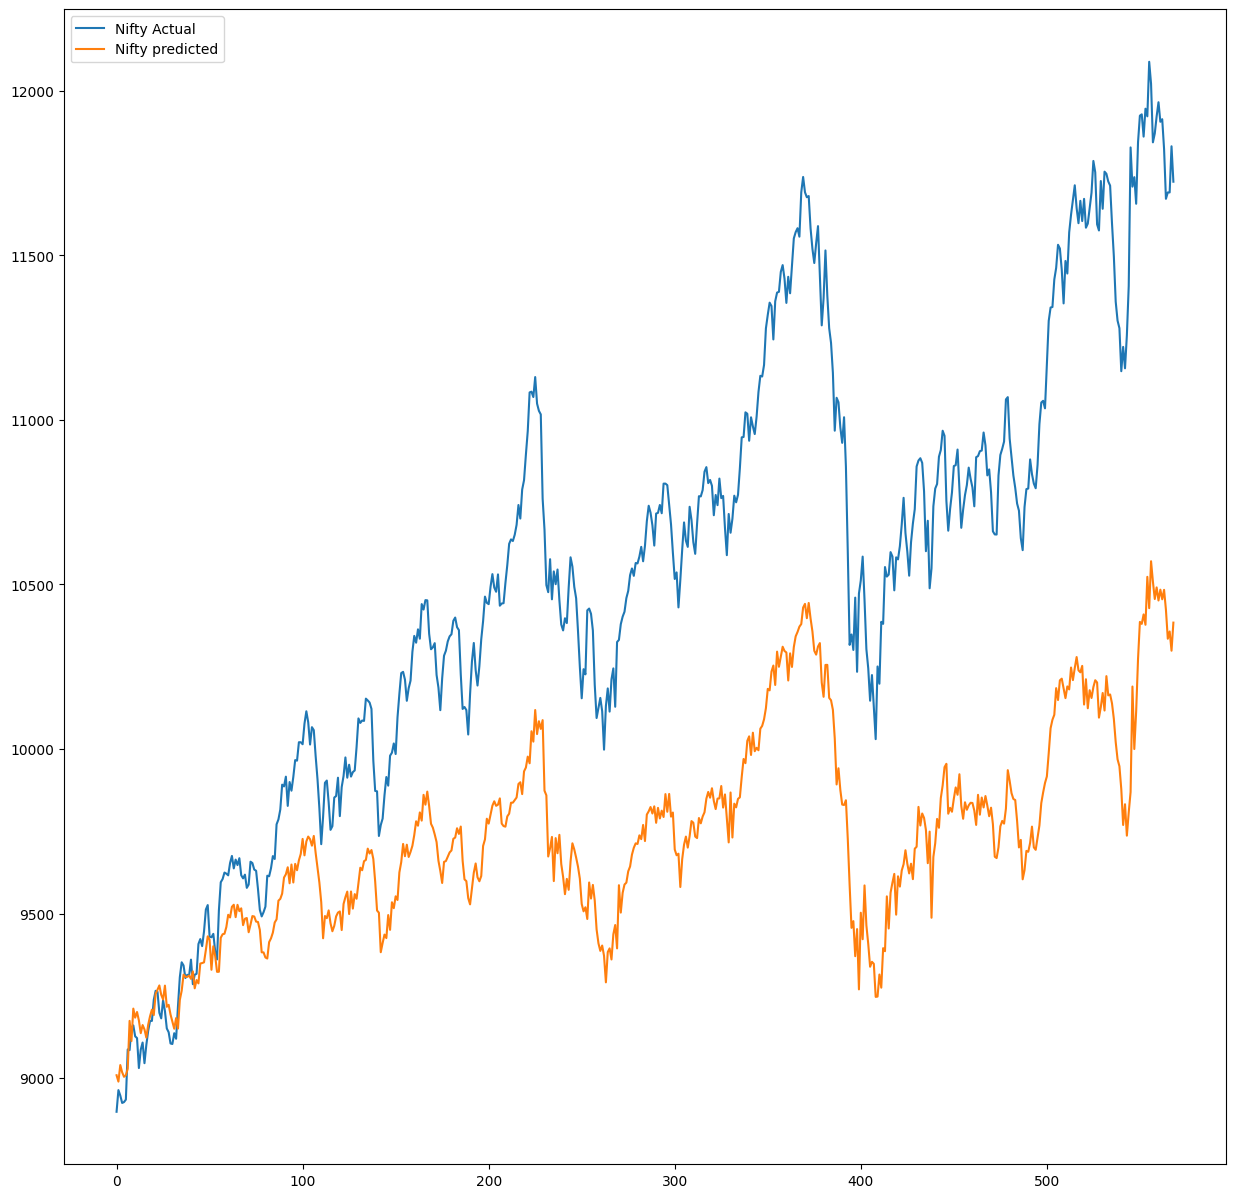

In [27]:
# Plot the Nifty with Actual v/s predicted
pyplot.figure(figsize=(15, 15))
pyplot.plot(inv_y, label='Nifty Actual')
pyplot.plot(inv_ypred, label='Nifty predicted')
pyplot.legend()
pyplot.show()  